In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(20)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.69:46147 Dashboard: http://146.118.38.69:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
import glob
import cmocean
import cartopy
import zarr

from matplotlib.colors import LightSource
from scipy import ndimage
# import geoviews as gv
# import geoviews.feature as gf

In [83]:
%matplotlib inline

In [86]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'

In [10]:
# Open the object as a zarr file
outpath = '/home/mrayson/scratch/HIMAWARI/raw_zarr'
ds = xr.open_zarr(outpath)
ds.time.values[0],ds.time.values[-1]

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'))

In [183]:
sst = ds['sea_surface_temperature'].sel(time=slice('2017-04-01','2017-06-01'),lon=slice(110,130),lat=slice(-10,-22))
sst2 = ds['sea_surface_temperature'].sel(time=slice('2019-03-01','2019-05-01'),lon=slice(110,130),lat=slice(-10,-22))

print(sst.nbytes/1e9,' GB')
sst

3.578322748  GB


<xarray.DataArray 'sea_surface_temperature' (time: 1487, lat: 601, lon: 1001)>
dask.array<getitem, shape=(1487, 601, 1001), dtype=float32, chunksize=(1, 601, 1001), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -10.0 -10.019997 -10.040001 ... -21.979996 -22.0
  * lon      (lon) float32 110.0 110.02 110.04 110.06 ... 129.95999 129.98 130.0
  * time     (time) datetime64[ns] 2017-04-01T00:00:17 ... 2017-06-01T23:00:17
Attributes:
    comment:        Temperature of the skin of the ocean.
    grid_mapping:   Equirectangular
    long_name:      sea surface skin temperature
    standard_name:  sea_surface_skin_temperature
    units:          kelvin
    valid_max:      5000
    valid_min:      -200

In [169]:
# Load some bathy data
dsz = xr.open_dataset('/home/mrayson/group/mrayson/DATA/BATHYMETRY//TimorSea_GAWEL_Multi_GEBCO_Combined_DEM.nc')
# dsz.set_coords({'X':dsz.X,'Y':dsz.Y})
# dsz.topo.swap_dims({'ny':dsz.Y.values, 'nx':dsz.X.values})
topo = xr.DataArray(dsz.topo.values, dims=('Y','X'), coords={'X':dsz.X.values, 'Y':dsz.Y.values})

In [199]:
# Smooth the SST image
def filt_image(sst_jan_C):
    s = 3
    w = 5
    t = (((w - 1)/2)-0.5)/s
    #sst_snap_C.values = ndimage.gaussian_filter(sst_snap_C, sigma=s, truncate=t)
    sst_jan_C.values = ndimage.gaussian_filter(sst_jan_C, sigma=s, truncate=t)
    return sst_jan_C

In [214]:
def plot_sst_scene(ax, temp,t1,t2, xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0) - 273.15
    mu_temp = filt_image(mu_temp)
    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)
    # plt.pcolormesh(temp.lon, temp.lat, dT, cmap='Blues',vmin=0, vmax=1e-4)
    P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    C = plt.contour(temp.lon, temp.lat, dT, [4e-5,],colors='k',linewidths=0.5)
    
    #topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
    #                levels=[-1000,-200],colors='0.5',linewidths=1, linestyles='--')
    
    plt.ylim(ylims)
    plt.xlim(xlims)

    plt.gca().set_aspect('equal')
    T = plt.text(116,-23,'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    {} - {}'.format(t1,t2))
    
    plt.tight_layout()
    
    return P, C, T

def plot_sstgrad_scene(ax, temp,t1,t2, lon,lat,xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0) - 273.15
    mu_temp = filt_image(mu_temp)

    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)*1e3
    C= plt.pcolormesh(temp.lon, temp.lat, dT, cmap=cmocean.cm.rain,vmin=5e-3, vmax=5e-2)
    #P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    #C2 = plt.contour(temp.lon, temp.lat, mu_temp.values, np.arange(22,31),colors='k',linewidths=0.5)
    if cbar:
        cb=plt.colorbar(C, orientation='horizontal', shrink=0.3, pad=-0.1)
        cb.ax.set_title(r'$|\nabla$SST|  [$^\circ$C km$^{-1}$]',color='k')
    
    topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
                    levels=np.arange(-1000,0,100),colors='k',linewidths=0.25, linestyles='-')
    
    plt.ylim(ylims)
    plt.xlim(xlims)
    # plt.ylim(-22,-16)
    # plt.xlim(114,120)
    ax=plt.gca()
    ax.set_aspect('equal')
    T = plt.text(0.05,0.2,\
            'Average Time:\n    {} - {}'.format(t1[0:11],t2[0:11]),
                transform=ax.transAxes)
    
    plt.tight_layout()
    plt.ylabel('')
    plt.xlabel('')
    plt.plot(lon,lat,'rd')
    
    plt.savefig('FIGURES/sst_grad_scene_{}_{}_90dpi.png'.format(t1[0:11],t2[0:11]),dpi=90)
    plt.savefig('FIGURES/sst_grad_scene_{}_{}_300dpi.png'.format(t1[0:11],t2[0:11]),dpi=300)

    return C, T
    


(<matplotlib.collections.QuadMesh at 0x2aae4e2d6f10>,
 Text(0.05, 0.2, 'Average Time:\n    2017-04-22  - 2017-04-25 '))

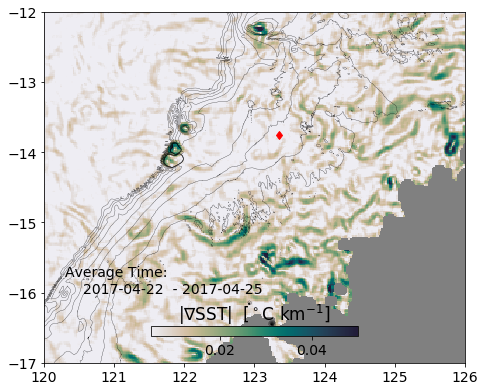

In [215]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst,'2017-04-22 12:00:00','2017-04-25 12:00:00',123.3535,-13.7621,
        xlims=(120,126.),ylims=(-17,-12))


(<matplotlib.collections.QuadMesh at 0x2aae4e500890>,
 Text(0.05, 0.2, 'Average Time:\n    2017-05-02  - 2017-05-05 '))

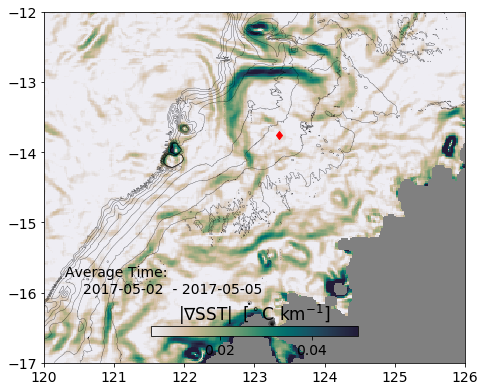

In [216]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst,'2017-05-02 12:00:00','2017-05-05 12:00:00',123.3535,-13.7621,
        xlims=(120,126.),ylims=(-17,-12))


(<matplotlib.collections.QuadMesh at 0x2aae4e79aad0>,
 Text(0.05, 0.2, 'Average Time:\n    2017-05-08  - 2017-05-11 '))

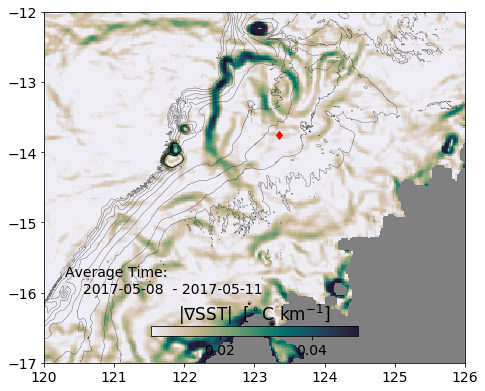

In [217]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst,'2017-05-08 12:00:00','2017-05-11 12:00:00',123.3535,-13.7621,
        xlims=(120,126.),ylims=(-17,-12))


(<matplotlib.collections.QuadMesh at 0x2aae3bc18f50>,
 Text(0.05, 0.2, 'Average Time:\n    2017-05-11  - 2017-05-14 '))

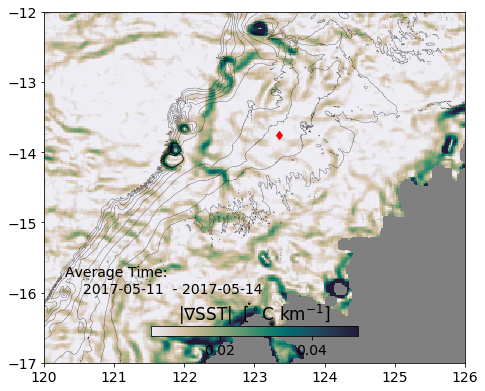

In [226]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst,'2017-05-11 12:00:00','2017-05-14 12:00:00',123.3535,-13.7621,
        xlims=(120,126.),ylims=(-17,-12))


(<matplotlib.collections.QuadMesh at 0x2aae4e9c75d0>,
 Text(0.05, 0.2, 'Average Time:\n    2019-04-03  - 2019-04-06 '))

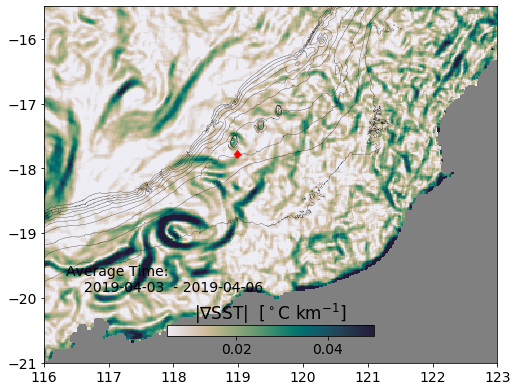

In [218]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst2,'2019-04-03 12:00:00','2019-04-06 12:00:00',118.9871,-17.7776,
        xlims=(116,123.),ylims=(-21,-15.5))


(<matplotlib.collections.QuadMesh at 0x2aae4e5006d0>,
 Text(0.05, 0.2, 'Average Time:\n    2019-04-01  - 2019-04-04 '))

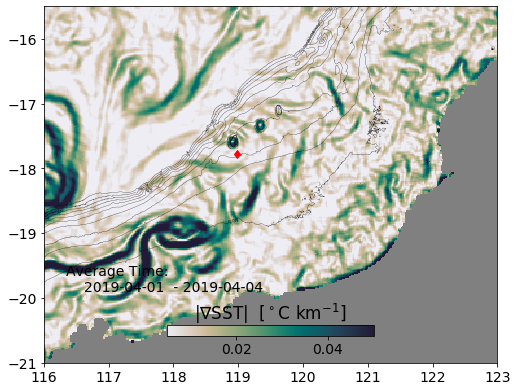

In [219]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst2,'2019-04-01 12:00:00','2019-04-04 12:00:00',118.9871,-17.7776,
        xlims=(116,123.),ylims=(-21,-15.5))


(<matplotlib.collections.QuadMesh at 0x2aae4ed887d0>,
 Text(0.05, 0.2, 'Average Time:\n    2019-03-28  - 2019-03-31 '))

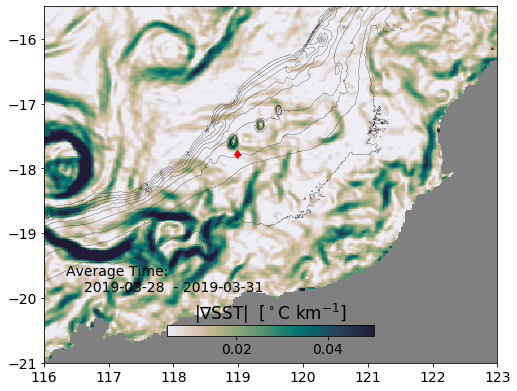

In [221]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, sst2,'2019-03-28 12:00:00','2019-03-31 12:00:00',118.9871,-17.7776,
        xlims=(116,123.),ylims=(-21,-15.5))


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a96d3668>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-15 12:00:00 - 2019-04-18 12:00:00'))

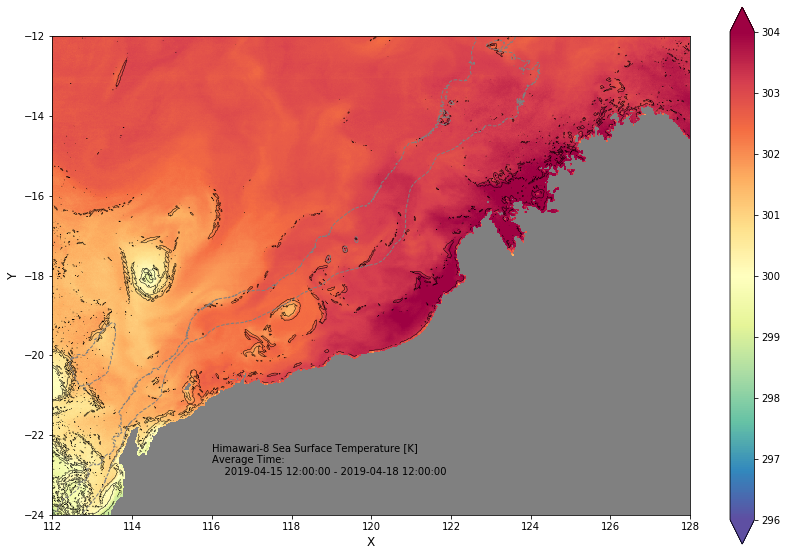

In [12]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-15 12:00:00','2019-04-18 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff097939390>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

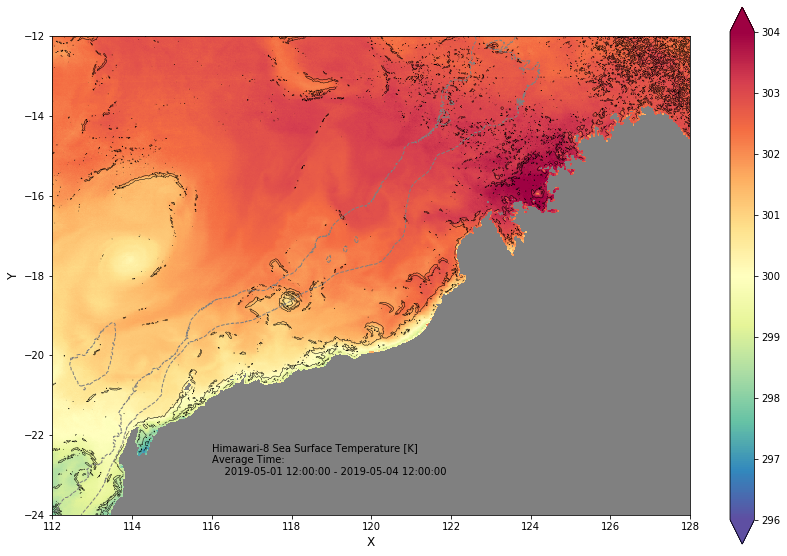

In [13]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff092973908>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

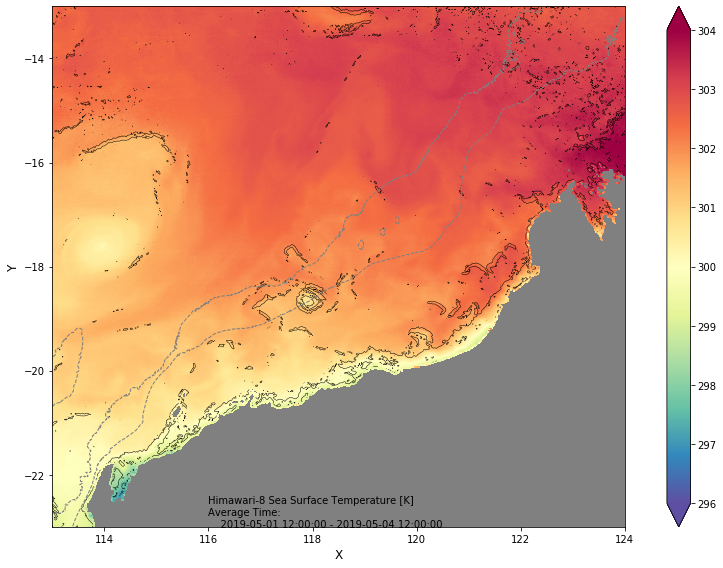

In [14]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff08da3f7b8>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-01 12:00:00 - 2019-04-04 12:00:00'))

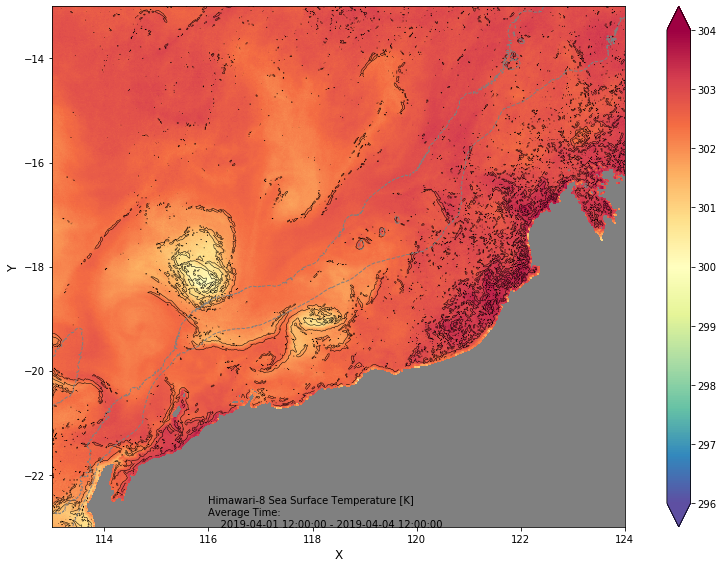

In [15]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-01 12:00:00','2019-04-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-28 00:00:00 2019-05-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-29 00:00:00 2019-06-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-30 00:00:00 2019-06-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-31 00:00:00 2019-06-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-01 00:00:00 2019-06-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-02 00:00:00 2019-06-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-03 00:00:00 2019-06-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-04 00:00:00 2019-06-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-05 00:00:00 2019-06-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-06 00:00:00 2019-06-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-07 00:00:00 2019-06-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-08 00:00:00 2019-06-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-09 00:00:00 2019-06-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-10 00:00:00 2019-06-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-11 00:00:00 2019-06-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-12 00:00:00 2019-06-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-13 00:00:00 2019-06-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-14 00:00:00 2019-06-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-15 00:00:00 2019-06-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-16 00:00:00 2019-06-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-17 00:00:00 2019-06-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-18 00:00:00 2019-06-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-19 00:00:00 2019-06-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-20 00:00:00 2019-06-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-21 00:00:00 2019-06-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-22 00:00:00 2019-06-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-23 00:00:00 2019-06-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-24 00:00:00 2019-06-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-25 00:00:00 2019-06-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-26 00:00:00 2019-06-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-27 00:00:00 2019-06-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-28 00:00:00 2019-07-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-29 00:00:00 2019-07-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-30 00:00:00 2019-07-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-01 00:00:00 2019-07-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-02 00:00:00 2019-07-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-03 00:00:00 2019-07-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-04 00:00:00 2019-07-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-05 00:00:00 2019-07-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-06 00:00:00 2019-07-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-07 00:00:00 2019-07-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-08 00:00:00 2019-07-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-09 00:00:00 2019-07-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-10 00:00:00 2019-07-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-11 00:00:00 2019-07-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-12 00:00:00 2019-07-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-13 00:00:00 2019-07-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-14 00:00:00 2019-07-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-15 00:00:00 2019-07-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-16 00:00:00 2019-07-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-17 00:00:00 2019-07-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-18 00:00:00 2019-07-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-19 00:00:00 2019-07-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-20 00:00:00 2019-07-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-21 00:00:00 2019-07-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-22 00:00:00 2019-07-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-23 00:00:00 2019-07-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-24 00:00:00 2019-07-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-25 00:00:00 2019-07-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-26 00:00:00 2019-07-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-27 00:00:00 2019-07-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-28 00:00:00 2019-07-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-29 00:00:00 2019-08-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-30 00:00:00 2019-08-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-31 00:00:00 2019-08-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-01 00:00:00 2019-08-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-02 00:00:00 2019-08-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-03 00:00:00 2019-08-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-04 00:00:00 2019-08-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-05 00:00:00 2019-08-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-06 00:00:00 2019-08-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-07 00:00:00 2019-08-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-08 00:00:00 2019-08-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-09 00:00:00 2019-08-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-10 00:00:00 2019-08-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-11 00:00:00 2019-08-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-12 00:00:00 2019-08-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-13 00:00:00 2019-08-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-14 00:00:00 2019-08-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-15 00:00:00 2019-08-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-16 00:00:00 2019-08-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-17 00:00:00 2019-08-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-18 00:00:00 2019-08-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-19 00:00:00 2019-08-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-20 00:00:00 2019-08-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-21 00:00:00 2019-08-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-22 00:00:00 2019-08-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-23 00:00:00 2019-08-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-24 00:00:00 2019-08-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-25 00:00:00 2019-08-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-26 00:00:00 2019-08-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-27 00:00:00 2019-08-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-28 00:00:00 2019-08-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-29 00:00:00 2019-09-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-30 00:00:00 2019-09-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-31 00:00:00 2019-09-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-01 00:00:00 2019-09-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-02 00:00:00 2019-09-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-03 00:00:00 2019-09-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-04 00:00:00 2019-09-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-05 00:00:00 2019-09-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-06 00:00:00 2019-09-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-07 00:00:00 2019-09-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-08 00:00:00 2019-09-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-09 00:00:00 2019-09-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-10 00:00:00 2019-09-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-11 00:00:00 2019-09-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-12 00:00:00 2019-09-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-13 00:00:00 2019-09-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-14 00:00:00 2019-09-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-15 00:00:00 2019-09-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-16 00:00:00 2019-09-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-17 00:00:00 2019-09-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-18 00:00:00 2019-09-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-19 00:00:00 2019-09-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-20 00:00:00 2019-09-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-21 00:00:00 2019-09-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


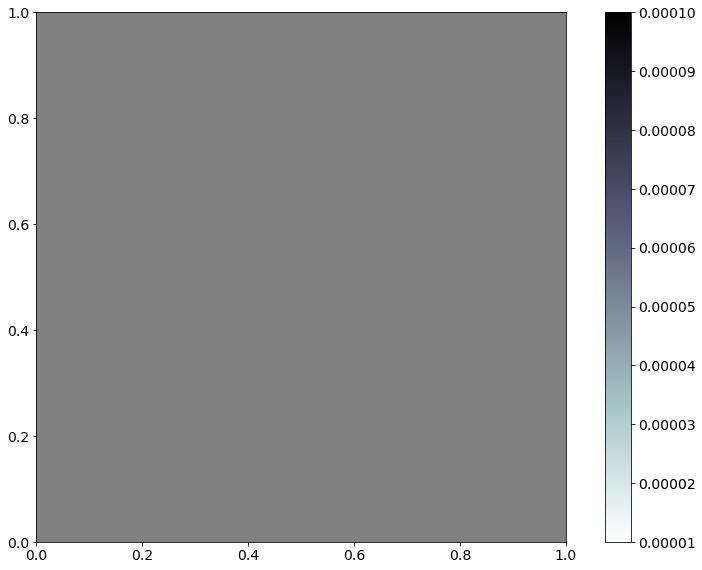

In [19]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-05-28', '2019-09-24',freq='D')

plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
C, T = plot_sstgrad_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    C, T = plot_sstgrad_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SSTgrad_{}.png'.format(t1)
    plt.savefig(outfile, dpi=90)
    plt.cla()

In [ ]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-06-30', '2019-09-24',freq='D')


plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
P, C, T = plot_sst_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    P, C, T = plot_sst_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SST_{}.png'.format(t1)
    plt.savefig(outfile, dpi=150)
    plt.cla()

